In [1]:
import pandas as pd
import requests
import yfinance as yf
import investpy
from bs4 import BeautifulSoup
from pymongo import MongoClient
import matplotlib.pyplot as plt

In [3]:
class Accion:
    def __init__(self, mercado, datosAccion):
        self.nombre = datosAccion[mercado.campo_nombre]
        self.max = datosAccion[mercado.campo_valorMaximo]
        self.min = datosAccion[mercado.campo_valorMinimo]
        self.ult = datosAccion[mercado.campo_UltimoPrecio]
        self.mov = datosAccion[mercado.campo_cambio]
        
class Origen:
    def __init__(self):
        self.__abrirColeccion()

    def __abrirColeccion(self):
        client = MongoClient('localhost')
        bd = client['cotizaciones']
        self.coleccion = bd[self.__class__.__name__]
        
    def _guardarEnBD(self, dataFrame):
        self.coleccion.drop()
        self.coleccion.insert_many(dataFrame.to_dict('records'))
        
    def visualizarBD(self):
        for documento in self.coleccion.find({}):
            print(documento)
            
    def visualizarDF(self):
        global df
        df = self.__documentADF(self.coleccion.find({}))
        #print (df)

    def __documentADF(self, listColeccion):
        global df
        df = pd.DataFrame(list(listColeccion))
        return df.drop(['_id'], axis=1)
        
    def gananciaPerdidaAcciones(self,dataFrame,columna,cantidad):
        global df
        df = df.sort_values(by=columna, ascending = False)
        print()
        print("Acciones de mayor ganancia\n",df.head(cantidad))
        print()
        print("Acciones de mayor pérdida\n",df.tail(cantidad))
    
    #vamos a graficar los valores positivos de un color y los negativos de otro color
    def graficarGananciaPerdida(self,dataFrame,x,y,titulo,nombre):
        global df
        dfMas=df[y]>=0 #seleccionamos los valores positivos
        dfPositivos = df[dfMas]
        dfPositivos = dfPositivos.rename({y: 'Ganancia'}, axis=1)  #renombramos la columna como Ganancia
        dfMenos=df[y]<0  #seleccionamos los valores negativos
        dfNegativos = df[dfMenos]
        dfNegativos = dfNegativos.rename({y: 'Pérdida'}, axis=1) #renombramos la columna como Pérdida
        df = pd.concat([dfPositivos,dfNegativos]).sort_values(by=x)   #unimos las tablas ordenadas por el nombre
        #armamos el gráfico 
        #parámetros: columnas, tipo de gráfico, ancho de las barras, colores de las barras
        plt.style.use('seaborn')
        df[[x, 'Ganancia', 'Pérdida']].plot(x, kind="bar", width=1, color=["#04D8B2","#EF4026"]) 
        plt.title(titulo) #título del grafico
        plt.xlabel('Acciones') #título del eje de las x
        #guardamos el gráfico, 'tight' s para que se guarde el gráfico de manera completa
        #parámetro: nombre
        plt.savefig(nombre, bbox_inches='tight')
        plt.tight_layout();plt.show() #mostramos el gráfico de manera completa

    def filtrarAcciones(self, nombreAccion):
        accion = self.coleccion.find({self.campo_nombre: {"$in": nombreAccion}})
        return print(self.__documentADF(accion))

    def accion(self, symbol):
        return Accion(self, self.coleccion.find_one({self.campo_nombre: symbol}))

         Nombre     Últ  % Dif    Máx     Mín    Volumen Efectivo (miles €)  \
0          BBVA   6.156  -0.10   6.16   6.064  5.422.526          33.119,71   
1        ENDESA  19.980  -0.99  20.13  19.870    420.397           8.403,55   
2  GRIFOLS CL.A  19.465  -1.74  19.86  19.400    284.692           5.574,92   
3       INDRA A  10.440   1.16  10.48  10.290    290.004           3.020,58   
4        REPSOL  10.664  -2.27  10.86  10.632  5.745.772          61.835,36   

        Fecha      Hora  
0  03/11/2021  15:08:48  
1  03/11/2021  15:07:24  
2  03/11/2021  15:08:46  
3  03/11/2021  15:08:03  
4  03/11/2021  15:08:42  

Acciones de mayor ganancia
         Nombre     Últ  % Dif     Máx      Mín     Volumen Efectivo (miles €)  \
19         IAG   1.978   3.13   2.006   1.9235  14.649.894          28.980,25   
28  PHARMA MAR  62.940   2.04  63.200  61.0400      67.863           4.228,93   

         Fecha      Hora  
19  03/11/2021  15:08:48  
28  03/11/2021  15:07:10  

Acciones de ma

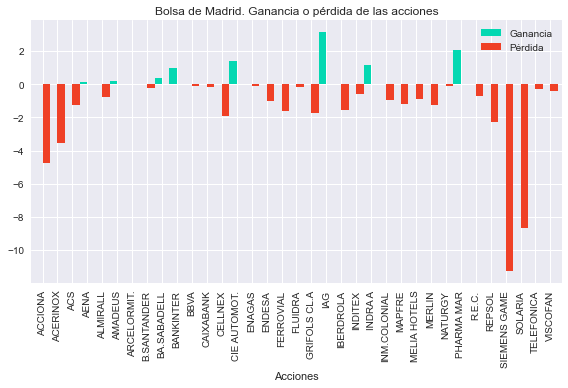

-0.1


In [4]:
       
class bolsaMadrid(Origen):
    def __init__(self):
        super().__init__()
        self.campo_nombre = 'Nombre'
        self.campo_valorMaximo = 'Máx'
        self.campo_valorMinimo = 'Mín'
        self.campo_UltimoPrecio = 'Últ'
        self.campo_cambio = '% Dif'
    
    def actualizarBD(self):
        #Hacemos la consulta a la pagina y guardamos el contenido en una variable soup
        url_page = 'https://www.bolsamadrid.es/esp/aspx/Mercados/Precios.aspx?indice=ESI100000000'
        page = requests.get(url_page).text 
        soup = BeautifulSoup(page, "lxml")

        #Buscamos la tabla de donde obtener los datos
        tabla = soup.find('table', attrs={'id': 'ctl00_Contenido_tblAcciones'})

        #creamos una lista vacia que llenaremos con los datos de las tablas
        columnas = []

        #buscamos los encabezados de la tabla y los agregamos a la lista columnos (deberia ubicarse en la posicion 0)
        headers = []
        for th in tabla.find_all('th'):
            headers.append(th.text.replace('.',''))
        columnas.append(headers)

        for tr in tabla.find_all('tr'):
            fila = []
            for td in tr.find_all('td'):
                fila.append(td.text)
            if len(fila) > 0:
                columnas.append(fila)
                
        #creamos el dataframe usando la lista columnas,pasamos el contenido (de la posicion 1 en adelante), y lo encabezados en (posicion 0)
        df = pd.DataFrame(columnas[1:], columns=columnas[0])

        #Convertirmos a float
        df = self.__convertirAFloat(df)

        #Guardamos los datos en la base de datos
        self._guardarEnBD(df)
        
    def __convertirAFloat(self, df):
        df["% Dif"] = df["% Dif"].str.replace(",", ".").astype(float)
        df["Máx"] = df["Máx"].str.replace(",", ".").astype(float)
        df["Mín"] = df["Mín"].str.replace(",", ".").astype(float)
        df["Últ"] = df["Últ"].str.replace(",", ".").astype(float)
        return df

nombreDeAcciones =[
    'BBVA', "BBVA.MC",
    'ELE', "ELE.MC", 'ENDESA',
    'GRLS', "GRF.MC", 'GRIFOLS CL.A',
    'INDRA A', 'IDR',"IDR.MC",
    "REP.MC", 'REP','REPSOL'
    ]

bolsamadrid = bolsaMadrid()
bolsamadrid.actualizarBD()
bolsamadrid.filtrarAcciones(nombreDeAcciones)
df_BM = bolsamadrid.visualizarDF()
bolsamadrid.gananciaPerdidaAcciones(df_BM,'% Dif',2)
bolsamadrid.graficarGananciaPerdida(df_BM, x='Nombre', y='% Dif', titulo='Bolsa de Madrid. Ganancia o pérdida de las acciones', nombre='Ganan_perd_BolsaMadrid.png')
accion = bolsamadrid.accion('BBVA')
print(accion.mov)

In [621]:
class yfinance(Origen):

    def __init__(self):
        super().__init__()
        self.campo_nombre = 'Ticker'
        self.campo_valorMaximo = 'High'
        self.campo_valorMinimo = 'Low'
        self.campo_UltimoPrecio = 'Close'
        self.campo_cambio = 'Dif'

    def actualizarBD(self, acciones):
        df_list = list()
        for accion in acciones:
            if not " " in accion and ".MC" in accion:
                data = yf.download(accion, group_by='ticker', period='1d')
                if not data.empty:
                    data['Ticker'] = accion
                    data['Dif'] = self.__calcularDiferencia(data['Open'], data['Close'])
                    df_list.append(data)

        if len(df_list) > 0:
            df = pd.concat(df_list)
            self._guardarEnBD(df)
    
    def __calcularDiferencia(self, A, B):
        return (B*100)/A-100

yahooFinance = yfinance()
yahooFinance.actualizarBD(nombreDeAcciones)
yahooFinance.visualizarBD()
yahooFinance.visualizarDF()


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
{'_id': ObjectId('618159315bc14ce365e80f12'), 'Open': 6.202000141143799, 'High': 6.254000186920166, 'Low': 6.140999794006348, 'Close': 6.173999786376953, 'Adj Close': 6.173999786376953, 'Volume': 7315483, 'Ticker': 'BBVA.MC', 'Dif': -0.4514729785491767}
{'_id': ObjectId('618159315bc14ce365e80f13'), 'Open': 20.040000915527344, 'High': 20.139999389648438, 'Low': 19.959999084472656, 'Close': 20.059999465942383, 'Adj Close': 20.059999465942383, 'Volume': 448569, 'Ticker': 'ELE.MC', 'Dif': 0.09979316118466386}
{'_id': ObjectId('618159315bc14ce365e80f14'), 'Open': 19.799999237060547, 'High': 19.815000534057617, 'Low': 19.594999313354492, 'Close': 19.760

  country     name symbol    last    high     low  change change_percentage  \
0   spain     BBVA   BBVA   6.173   6.174   6.060  +0.011            +0.18%   
1   spain  Grifols   GRLS  19.475  19.825  19.395  -0.337            -1.70%   
2   spain   Repsol    REP  10.672  10.853  10.630  -0.219            -2.01%   
3   spain  Indra A    IDR  10.455  10.480  10.295  +0.135            +1.31%   
4   spain   Endesa    ELE  20.002  20.180  19.867  -0.138            -0.69%   

   turnover currency    GP  %  
0   5420000      EUR  0.18  %  
1    285140      EUR -1.70  %  
2   2740000      EUR -2.01  %  
3    290000      EUR  1.31  %  
4    420740      EUR -0.69  %  

Acciones de mayor ganancia
    country          name symbol    last    high     low  change  \
33   spain  Laborat.Rovi   ROVI  63.800  63.800  60.600  +3.000   
27   spain           IAG   ICAG   1.982   2.006   1.918  +0.064   

   change_percentage  turnover currency    GP  %  
33            +4.93%    112020      EUR  4.93  %  


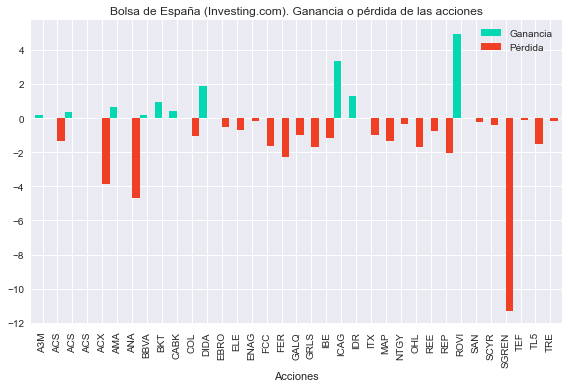

' invest.visualizarBD()\ninvest.visualizarDF() '

In [5]:
class investPy(Origen):

    def __init__(self):
        super().__init__()
        self.campo_nombre = 'symbol'
        self.campo_valorMaximo = 'high'
        self.campo_valorMinimo = 'low'
        self.campo_UltimoPrecio = 'last'
        self.campo_cambio = 'DP'

    def actualizarBD(self):
        df = investpy.stocks.get_stocks_overview(country='spain', as_json = False , n_results = 35)  
        df = self.__porcentajeCambio(df)
        #cambiar la columna a numérica
        df['GP'] = df['GP'].apply(pd.to_numeric)
        self._guardarEnBD(df)
    
    def __porcentajeCambio(self, df):
        return df.join(df['change_percentage'].str.partition('%')[[0, 1]]).rename({0: 'GP', 1: '%'}, axis=1)

invest = investPy()
invest.actualizarBD()
invest.filtrarAcciones(nombreDeAcciones)
df_Invest = invest.visualizarDF()
invest.gananciaPerdidaAcciones(df_Invest,'GP',2)
invest.graficarGananciaPerdida(df_Invest, x='symbol', y='GP', titulo='Bolsa de España (Investing.com). Ganancia o pérdida de las acciones', nombre='Ganan_perd_Investpy.png')
""" invest.visualizarBD()
invest.visualizarDF() """


In [624]:
class Cotizaciones(bolsaMadrid, yfinance, investPy):

    def __init__(self, acciones):
        self.acciones = acciones
        self.actualizarBD()
       

    def actualizarBD(self):
        bolsaMadrid.obtenerDatos(self)
        yfinance.obtenerDatos(self.acciones)
        ##investpy.obtenerDatos(self)

    def leerDatos():
        pass

In [625]:
acciones = ['ACCIONA', 'BBVA', 'GRIFOLS CL.A', 'PEPITO', 'REPSOL', 'ENDESA']
cotizaciones = Cotizaciones(acciones)
cotizaciones.mostrarDatosEnPantalla()


AttributeError: type object 'bolsaMadrid' has no attribute 'obtenerDatos'